In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import catboost
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from utils import add_info, make_features, compute_metric

SEED = 42

In [3]:
train = pd.read_excel('data/train.xlsx')

Достаем информацию из дополнительных данных

In [5]:
train = add_info(train)

month_stats = dict(train.groupby('month')['Изменение цены на арматуру'].median())
train['Изменение в месяце'] = train['month'].apply(lambda x: month_stats[x])

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_1004/1704882117.py:72: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  magn_stock = pd.read_csv(


In [7]:
# На какое количество недель можем предсказывать
SLICE = 9

X_data, y_data = [], []
for i in range(20, len(train)-10):
    cur_df = train.iloc[:i] # Данные, которые у нас есть
    X_data.append(make_features(cur_df))

    cur_targets = []
    next_price = train['Цена на арматуру'][i:i+SLICE].tolist() # Цены в следующие моменты времени
    for i in range(len(next_price)):
        # Если цена пойдет выше -> надо покупать, тогда ставим 1, иначе - 0
        cur_targets.append(next_price[i] - cur_df['Цена на арматуру'].tolist()[-1])

    y_data.append(cur_targets)

# В первых 5 строках много пустых значений
X_data, y_data = np.array(X_data[5:]), np.array(y_data[5:])

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_1004/1220337617.py:69: RuntimeWarning: Mean of empty slice
  np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-2]\
/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_1004/1220337617.py:73: RuntimeWarning: Mean of empty slice
  np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-5]\
/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_1004/1220337617.py:78: RuntimeWarning: Mean of empty slice
  np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-10]\
/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_1004/1220337617.py:83: RuntimeWarning: Mean of empty slice
  np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-20]\
/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_1004/1220337617.py:91: RuntimeWarning: Mean of empty slice
  np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-2]\
/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_1004/1220337617.py:94: RuntimeWarning: Mean of empty slice
  np.nanmean([df[x].tolis

{'iterations': 1000,
 'learning_rate': 0.03,
 'thread_count': 6,
 'random_seed': 42,
 'verbose': False,
 'eval_metric': 'AUC',
 'depth': 4,
 'l2_leaf_reg': 4,
 'random_strength': 1.4,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli'}

In [8]:
best_params = {'iterations': 2000,
 'learning_rate': 0.03,
 'thread_count': 6,
 'random_seed': 42,
 'verbose': False,
 'depth': 4,
 'l2_leaf_reg': 4,
 'random_strength': 1.4,
 'loss_function': 'MAE',
 'early_stopping_rounds': 400,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli'}

In [9]:
models = []
scores = []
threshold = []
all_preds = np.zeros((SLICE, len(y_data)))

for slice in tqdm(range(SLICE)):
    cur_target = y_data[:, slice].tolist()
    for x in range(6):
        X_train = np.array(X_data[:x*(len(X_data)//6+1)].tolist() + X_data[(x+1)*(len(X_data)//6+1):].tolist())
        X_valid = np.array(X_data[x*(len(X_data)//6+1):(x+1)*(len(X_data)//6+1)])

        y_train = np.array(cur_target[:x*(len(cur_target)//6+1)] + cur_target[(x+1)*(len(cur_target)//6+1):])
        y_valid = np.array(cur_target[x*(len(cur_target)//6+1):(x+1)*(len(cur_target)//6+1)])

        model = CatBoostRegressor(**best_params)
        model.fit(X_train, y_train, eval_set=Pool(X_valid, y_valid))
        
        importance = pd.DataFrame({
            'col': list(range(X_train.shape[1])),
            'imp': model.get_feature_importance()
        }).sort_values('imp')
        good_cols = importance[importance > 0.1].dropna().col.astype('int').to_numpy()
        model.fit(X_train[:, good_cols], y_train, eval_set=Pool(X_valid[:, good_cols], y_valid))
        preds = model.predict(X_valid[:, good_cols])
        
        all_preds[slice, x*(len(cur_target)//6+1):(x+1)*(len(cur_target)//6+1)] = preds

  0%|          | 0/9 [00:00<?, ?it/s]

132
138
124
126
135
129


 11%|█         | 1/9 [02:09<17:18, 129.85s/it]

136
126
136
89
131
132


 22%|██▏       | 2/9 [05:01<18:02, 154.65s/it]

139
129
133
126
136
120


 33%|███▎      | 3/9 [08:02<16:38, 166.49s/it]

138
131
115
43
129
125


 44%|████▍     | 4/9 [11:28<15:10, 182.10s/it]

133
128
47
47
134
106


 56%|█████▌    | 5/9 [14:41<12:24, 186.02s/it]

127
124
69
49
126
75


 67%|██████▋   | 6/9 [17:49<09:19, 186.59s/it]

123
118
123
36
130
45


 78%|███████▊  | 7/9 [20:58<06:15, 187.62s/it]

118
123
116
22
21
72


 89%|████████▉ | 8/9 [23:56<03:04, 184.33s/it]

123
112
122
25
29
64


100%|██████████| 9/9 [26:29<00:00, 176.66s/it]


Мы сэкономили 4.85%


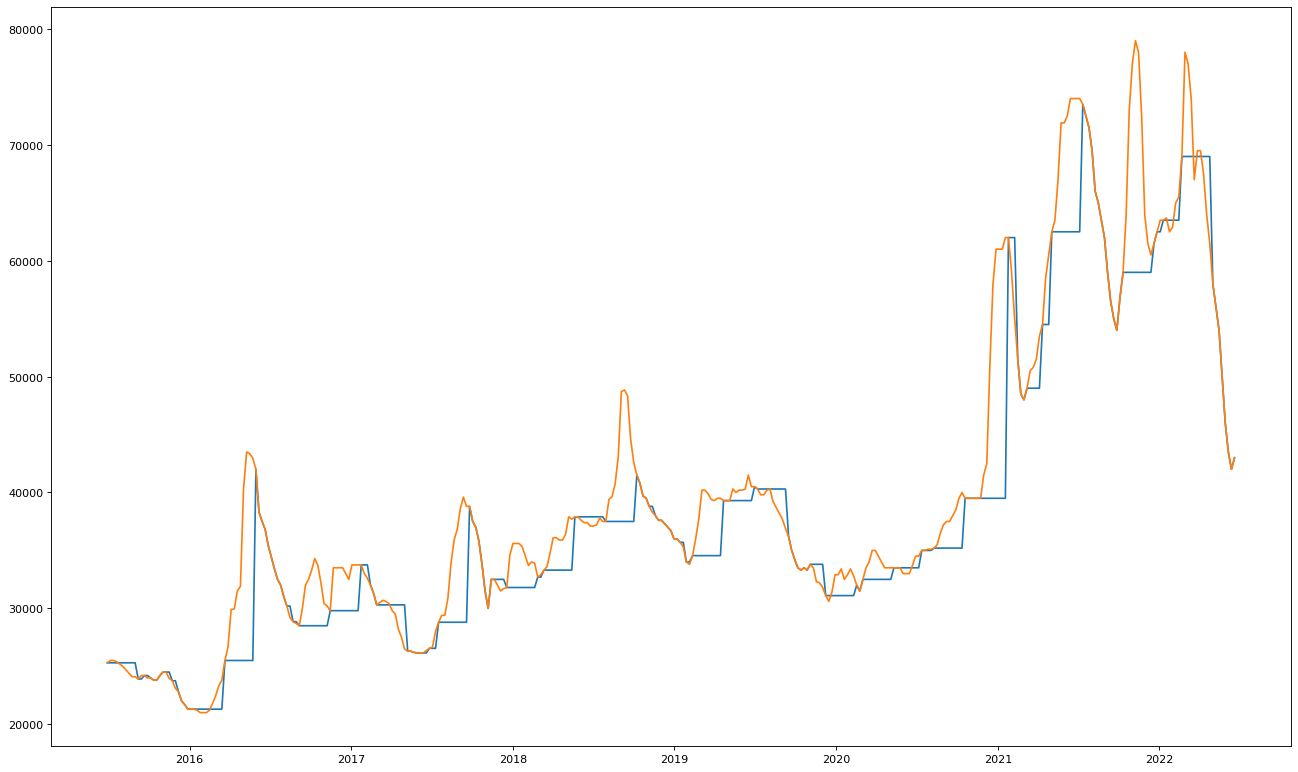

In [14]:
from matplotlib.pyplot import figure

figure(figsize=(20, 12), dpi=80)

test_preds = []
cur_df = train[25:-10][['dt', 'Цена на арматуру']]
for i in range(all_preds.shape[1]):
    cur_preds = all_preds[:, i]
    pred = 1
    for c, x in enumerate(cur_preds):
        if x > -250:
            pred += 1
        else:
            break
    test_preds.append(pred)
final_preds = []
next = 0
for id, x in enumerate(test_preds):
    if id == next:
        final_preds.append(min(x, len(test_preds)-len(final_preds)))
        for _ in range(x-1):
            if len(final_preds) < len(cur_df):
                final_preds.append(0)
        next = id + x

cur_df['Объем'] = final_preds
a = compute_metric(cur_df)

tmp = []
for ob, price in zip(cur_df['Объем'], cur_df['Цена на арматуру']):
    for _ in range(ob):
        tmp.append(price)
plt.plot(cur_df.dt, tmp)
cur_df['Объем'] = 1
b = compute_metric(cur_df)
print(f"Мы сэкономили {round((1-a/b)*100, 2)}%")
plt.plot(cur_df.dt, cur_df['Цена на арматуру'])

In [ ]:
import pickle
pickle.dump([models, month_stats], open('new_models.pkl', 'wb'))